# Introduction

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging).


# Installation

- S3Fs is a pythonic file interface to AWS S3 cloud storage (all the needed data is stored here).
- ngcasa is the prototype for the next generation of CASA software.
- graphviz is required for visualizing the task graph.



In [13]:
import os
os.system("pip install s3fs")
os.system("pip install ngcasa==0.0.2")
os.system("pip install graphviz")
print("complete")

complete


# Load Data from AWS S3 Cloud


In [27]:
import s3fs
import xarray as xr

# Initialize the S3 "file system"
s3 = s3fs.S3FileSystem(anon=True, requester_pays=False)

# Specify AWS S3 paths
bucket = "cngi-prototype-test-data/"
s3_path = bucket+"test_data/"

if s3.isdir(s3_path): # it's working
    print("Files available for access:")
    print(s3.listdir(s3_path))

ddi = "0"
s3_vis = s3_path+"sis14_twhya_field5_mstrans_lsrk.vis.zarr/"+ddi
s3_metadata = s3_path+"sis14_twhya_field5_mstrans_lsrk.vis.zarr/global"
s3_img = s3_path+"continuum_twhya_standard_gridder.img.zarr"

# Convert object stores to our desired MutableMapping interface
store_vis = s3fs.S3Map(root=s3_vis, s3=s3, check=False)
store_global = s3fs.S3Map(root=s3_metadata, s3=s3, check=False)
store_img = s3fs.S3Map(root=s3_img, s3=s3, check=False)

# Read zarr files
#vis_xds = xr.open_zarr(store=store_vis, consolidated=False,chunks={'chan':192})
vis_xds = xr.open_zarr(store=store_vis, consolidated=False)
global_xds = xr.open_zarr(store=store_global, consolidated=False)
casa_img_xds = xr.open_zarr(store=store_img, consolidated=False)

print('##############################################')
print(vis_xds)
print('##############################################')
print(casa_img_xds)
print('##############################################')
print('complete')

Files available for access:
[{'Key': 'cngi-prototype-test-data/test_data/', 'LastModified': datetime.datetime(2020, 3, 4, 16, 38, 17, tzinfo=tzutc()), 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"', 'Size': 0, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 0, 'name': 'cngi-prototype-test-data/test_data/'}, {'Key': 'cngi-prototype-test-data/test_data/continuum_twhya_standard_gridder.img.zarr', 'Size': 0, 'StorageClass': 'DIRECTORY', 'type': 'directory', 'size': 0, 'name': 'cngi-prototype-test-data/test_data/continuum_twhya_standard_gridder.img.zarr'}, {'Key': 'cngi-prototype-test-data/test_data/cube_twhya_standard_gridder.img.zarr', 'Size': 0, 'StorageClass': 'DIRECTORY', 'type': 'directory', 'size': 0, 'name': 'cngi-prototype-test-data/test_data/cube_twhya_standard_gridder.img.zarr'}, {'Key': 'cngi-prototype-test-data/test_data/sis14_twhya_field5_mstrans_lsrk.ms', 'Size': 0, 'StorageClass': 'DIRECTORY', 'type': 'directory', 'size': 0, 'name': 'cngi-prototype-test-data/test_data/sis1

/users/jsteeb/miniconda3/envs/ngcasa/lib/python3.6/site-packages/xarray/backends/zarr.py:646: UserWarning: Specified Dask chunks 192 would separate Zarr chunk shape 384 for dimension 'chan'. This significantly degrades performance. Consider rechunking after loading instead.
  chunk_spec = get_chunk(name, var, chunks)


##############################################
<xarray.Dataset>
Dimensions:        (baseline: 210, chan: 384, pair: 2, pol: 2, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas       (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline       (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan           (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width     (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    corr_product   (receptor, pol) int32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    effective_bw   (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    field          (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval       (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation    (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>
  * pol            (pol) int32 9 12
    processor      (time) <U14 dask.array<chunksize=

# Initialize the Processing Environment
InitializeFramework instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well.  The code is shown here commented out for reference only.

In [32]:
# normally you would want to run something like this on a local machine
#from cngi.direct import InitializeFramework
#client = InitializeFramework(workers=2, memory='6GB')
#print(client)

# Make Dirty Image

In [51]:
from ngcasa.synthesis import dirty_image
import dask

# Average weights to follow CASA math. See code/msvis/MSVis/VisImagingWeight.cc VisImagingWeight::unPolChanWeight
weights = (vis_xds.WEIGHT.values[:, :, 0] + vis_xds.WEIGHT.values[:, :, 1])/2 
weight = vis_xds.data_vars["WEIGHT"]
weight_avg = xr.DataArray.expand_dims((weight[:, :, 0] + weight[:, :, 1]) / 2, dim=['n_pol'], axis=2)
isel_vis_xds = vis_xds.isel(pol=[0]) #Select only one polarization
isel_vis_xds["WEIGHT"] = weight_avg
    
#Set parameters used by gridder    
grid_parms = {}
grid_parms["chan_mode"] = "continuum"#cube or continuum
grid_parms["imsize"] =  [200,400]
grid_parms["cell"] = [0.08, 0.08]    #in arcseconds
grid_parms["oversampling"] = 100
grid_parms["support"] = 7
#If "to_disk" is True dirty_image will execute the graph and save the xarray dataset to disk (img.zarr)
grid_parms["to_disk"] =  False 
#If 'to_disk' is True the name of the saved file
#grid_parms["outfile"] = "sis14_twhya_field5_mstrans_lsrk.img.zarr"

#Create graph 
img_xds = dirty_image(isel_vis_xds,grid_parms)
#Even if "to_disk" is True img_xds will not be persisted to memory.

# Visualizing the task graph.The graph will not display in the notebook, however the generated png can be viewed.
#img_xds.DIRTY_IMAGE.data.visualize('dirty_image_graph.png') 

print('##############################################')
print(img_xds)
print('##############################################')
print('complete')


{'chan_mode': 'continuum', 'imsize': [200, 400], 'cell': [0.08, 0.08], 'oversampling': 100, 'support': 7, 'to_disk': False}
##############################################
<xarray.Dataset>
Dimensions:         (chan: 1, d0: 200, d1: 400, pol: 1)
Coordinates:
  * d0              (d0) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * d1              (d1) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * chan            (chan) float64 3.726e+11
  * pol             (pol) int64 0
Data variables:
    CORRECTING_CGK  (d0, d1) float64 dask.array<chunksize=(200, 400), meta=np.ndarray>
    SUM_WEIGHT      (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    DIRTY_IMAGE     (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 400, 1, 1), meta=np.ndarray>
##############################################
complete


# Compare CASA and NGCASA Dirty Images

Dirty Image creation time 8.246058940887451


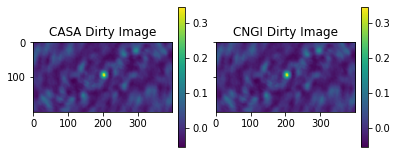

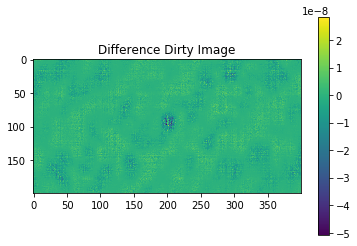

In [52]:
import matplotlib.pylab as plt
import time

#The actual compute is triggered here
start_time = time.time()
persist_img_xds = dask.compute(img_xds)[0] 
print('Dirty Image creation time', time.time()-start_time)

corrected_dirty_image = persist_img_xds.DIRTY_IMAGE.data[:,:,0,0]
casa_corrected_dirty_image = casa_img_xds['residual'].values[:, :, 0, 0]

fig0, ax0 = plt.subplots(1, 2, sharey=True)
im0 = ax0[0].imshow(casa_corrected_dirty_image)
im1 = ax0[1].imshow(corrected_dirty_image)
ax0[0].title.set_text('CASA Dirty Image')
ax0[1].title.set_text('CNGI Dirty Image')
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
plt.show()
        
plt.figure()
plt.imshow(casa_corrected_dirty_image - corrected_dirty_image)
plt.title('Difference Dirty Image')
plt.colorbar()
plt.show()



